In [ ]:
import warnings , os, re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.utils import np_utils

from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters, Choice

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

Create molecule

In [ ]:
ala = Chem.MolFromSmiles( 'N[C@@H](C)C(O)=O' )
ala

In [ ]:
Chem.MolToSmiles(ala)

In [ ]:
Chem.MolToMolBlock(ala)

In [ ]:
Chem.MolToInchi(ala)

3D Coordinates - Geometry optimization

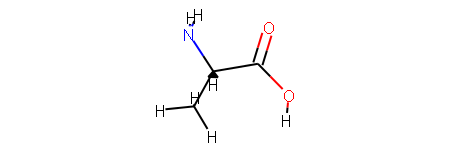

In [34]:
ala = Chem.MolFromSmiles( 'N[C@@H](C)C(O)=O' )
alaH = Chem.AddHs(ala)
rdDistGeom.EmbedMolecule(alaH)
alaH

Before= 14.244253317826994
After= 10.049570412761835


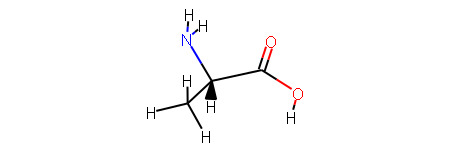

In [35]:
ff = AllChem.UFFGetMoleculeForceField(alaH)
print( "Before=", ff.CalcEnergy() )
AllChem.UFFOptimizeMolecule(alaH)
print( "After=", ff.CalcEnergy() )
alaH

Descriptors, Fingerprints

In [36]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols

165.192 0.6409999999999993 1 63.32


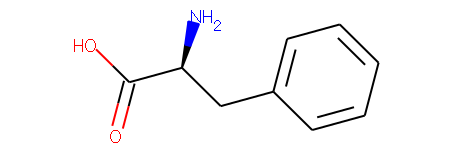

In [38]:
phe = Chem.MolFromSmiles('N[C@H](C(O)=O)Cc1ccccc1')
print( Descriptors.MolWt(phe), Descriptors.MolLogP(phe), Descriptors.RingCount(phe), Descriptors.TPSA(phe) )
phe

Database

306-molecules read...


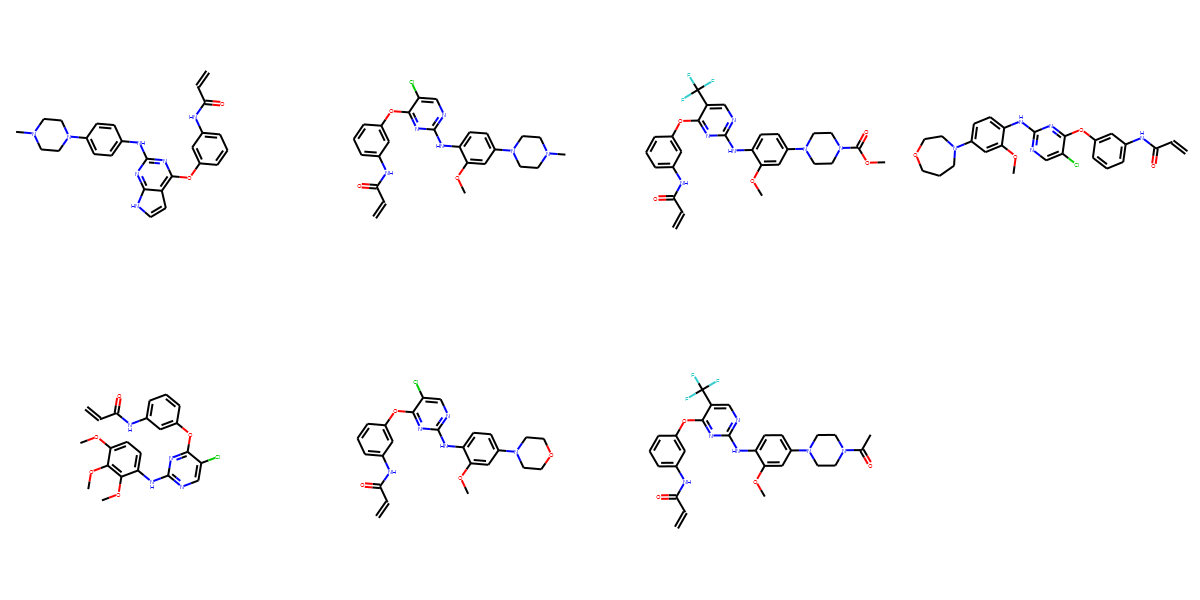

In [39]:
def mol_from_smiles( row ) :
    smiles = row[ 'smiles' ]
    m = Chem.MolFromSmiles( smiles )
    activity = row[ 'pChembl_Value' ]
    m.SetProp( 'pChembl_Value', str(activity) )
    return m


url_smi = 'https://raw.githubusercontent.com/chchae/VSLecture/master/data/egfr/ChEMBL27_EGFR_aminopyridine.smi'
db_smi = pd.read_table( url_smi, delimiter=' ', names=['smiles', 'pChembl_Value'], header=None, )
mols_egfr = [ mol_from_smiles(row) for _, row in db_smi.iterrows() ]

print( '%d-molecules read...' % len(mols_egfr) )
Draw.MolsToGridImage( mols_egfr[:7], molsPerRow=4, subImgSize=(300,300) )

Substructure search

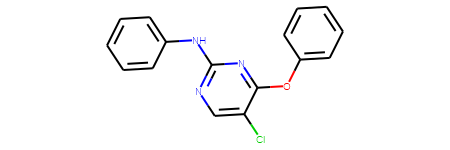

In [50]:
smiles = 'c1cc(ccc1Nc1ncc(Cl)c(Oc2ccccc2)n1)'
query = Chem.MolFromSmiles( smiles )
AllChem.Compute2DCoords(query)
query

Found =  81  from  306


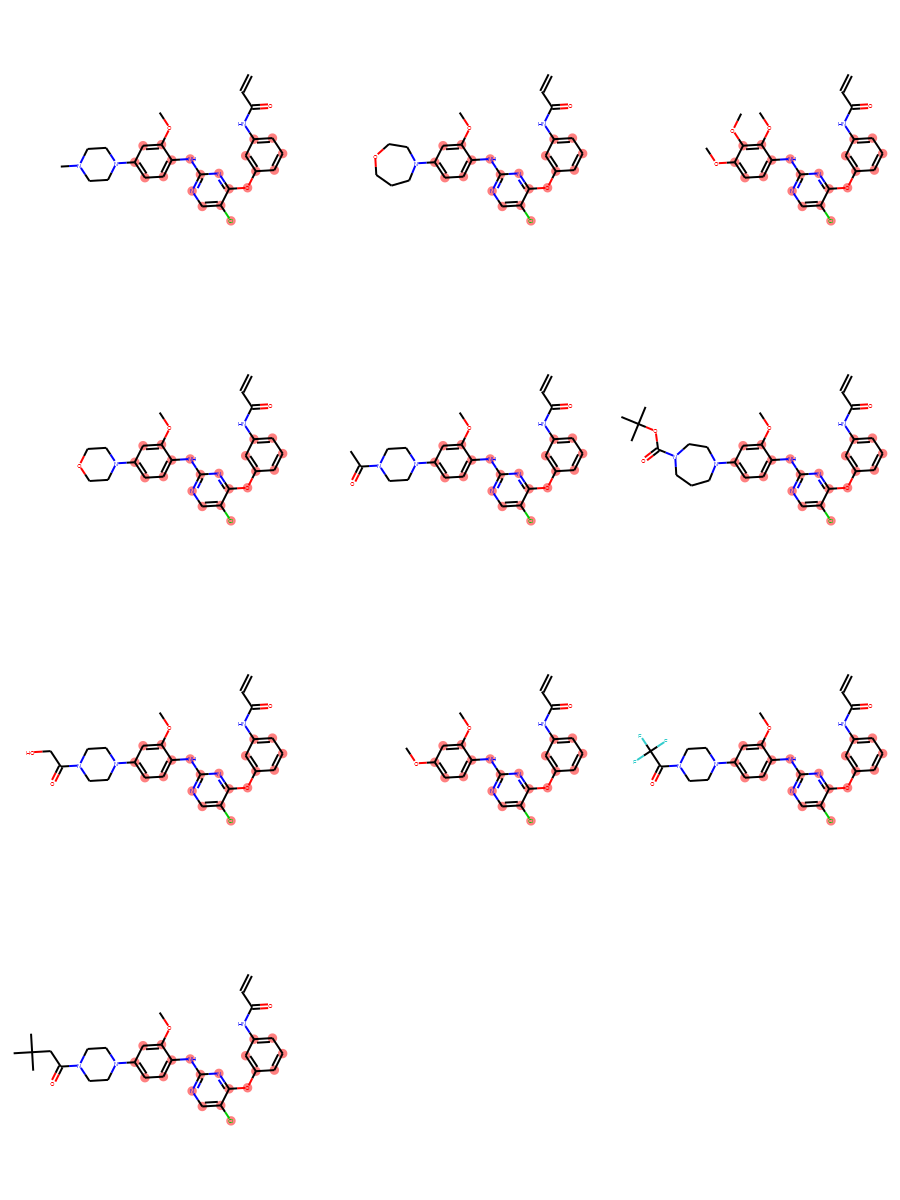

In [51]:
result = [ x for x in mols_egfr if x.HasSubstructMatch(query) ]
print( "Found = ", len( result ), " from ", len( mols_egfr ) )
for m in result:
    AllChem.GenerateDepictionMatching2DStructure( m, query )

Draw.MolsToGridImage( result[:10], molsPerRow=3, subImgSize=(300,300), highlightAtomLists=[ m.GetSubstructMatch(query) for m in result ]  )

MCS

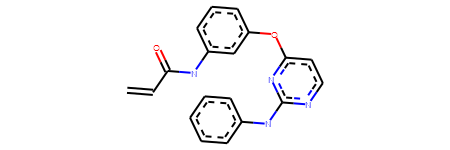

In [66]:
from rdkit.Chem import rdFMCS

mols_sub = mols_egfr[:20]
mcsf = rdFMCS.FindMCS( mols_sub )
mcs = Chem.MolFromSmarts( mcsf.smartsString )
mcs

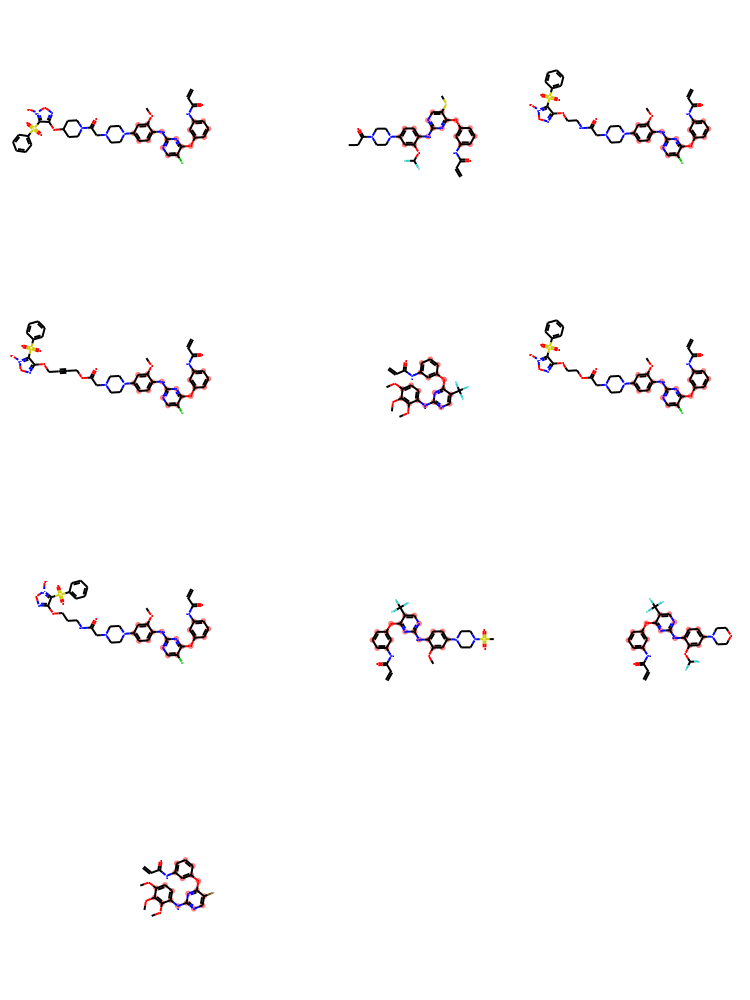

In [62]:
Draw.MolsToGridImage( mols_sub[:10], molsPerRow=3, subImgSize=(250,250), highlightAtomLists=[ m.GetSubstructMatch(mcs) for m in mols_sub ] )

R-Group decomposition

81 225
[{'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': '[H][*:5]', 'R6': 'CN1CCN([*:6])CC1'}, {'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': '[H][*:5]', 'R6': 'C1COCCN([*:6])C1'}, {'Core': 'Clc1cnc(Nc2ccc([*:6])c([*:5])c2[*:4])nc1Oc1ccc([*:3])c([*:2])c1[*:1]', 'R1': '[H][*:1]', 'R2': 'C=CC(=O)N[*:2]', 'R3': '[H][*:3]', 'R4': 'CO[*:4]', 'R5': 'CO[*:5]', 'R6': 'CO[*:6]'}]


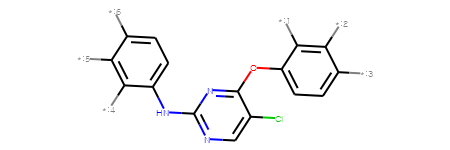

In [70]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD

mcsf = rdFMCS.FindMCS( mols_egfr )
mcs = Chem.MolFromSmarts( mcsf.smartsString )
mcs = query

matched,unmatched = rdRGD.RGroupDecompose([mcs],mols_egfr[:],asSmiles=True)
print( len(matched), len(unmatched) )
print( matched[:3] )
Chem.MolFromSmiles( matched[4]['Core'])

Fingerprints

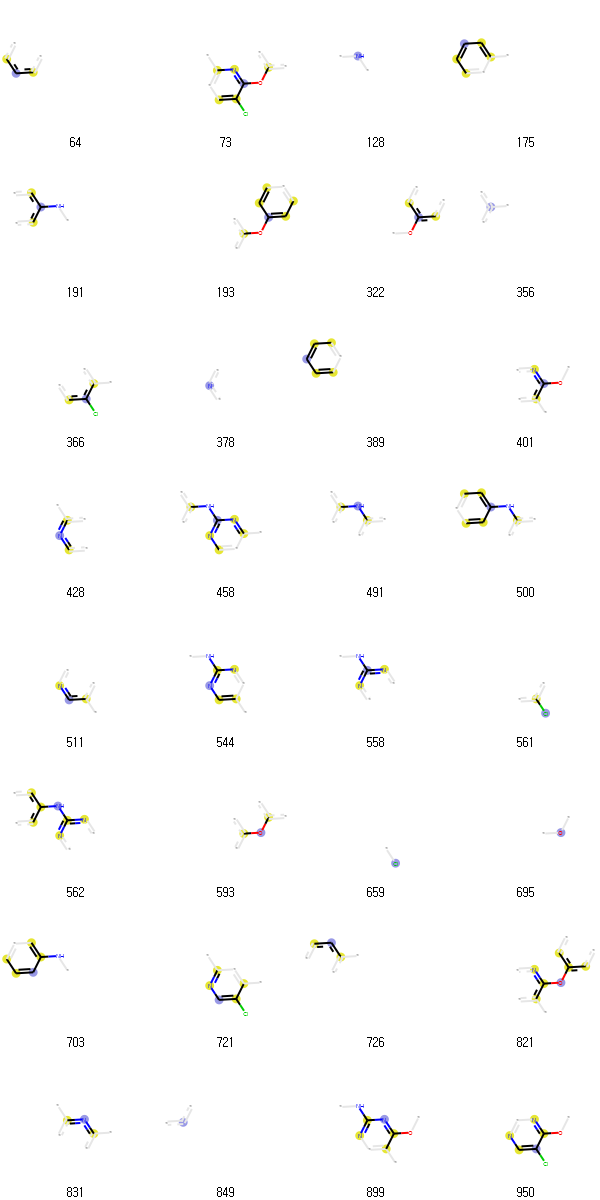

In [78]:
from rdkit.Chem.Fingerprints import FingerprintMols

ala = Chem.MolFromSmiles( 'CC(C(=O)O)N' )
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect( ala, 2, nBits=1024, bitInfo=bi )
#fp_arr = np.zeros( (1, ) )
#DataStructs.ConvertToNumpyArray( fp, fp_arr )
#np.nonzero( fp_arr )
#list( fp.GetOnBits() )

mfps = [ ( ala, x, bi ) for x in fp.GetOnBits() ]
Draw.DrawMorganBits( mfps, molsPerRow=4, subImgSize=(150,150), legends=[ str(x) for x in fp.GetOnBits() ] )

Fingerprint similarity search

In [82]:
fps = [ FingerprintMols.FingerprintMol(m) for m in mols_egfr ]
fp_ref = fps[1]

val = []
for i in range(len(fps)):
    val.append( DataStructs.FingerprintSimilarity( fp_ref, fps[i] ) )
print( np.array_str( np.array(val), precision=2 ) )

[0.65 1.   0.75 0.88 0.8  0.93 0.77 0.73 0.96 0.71 0.84 0.95 0.72 0.85
 0.92 0.69 0.68 0.91 0.72 0.61 0.67 0.73 0.88 0.88 0.76 0.89 0.87 0.76
 0.63 0.77 0.61 0.75 0.64 0.63 0.66 0.63 0.64 0.71 0.71 0.68 0.62 0.79
 0.73 0.85 0.63 0.63 0.7  0.6  0.77 0.63 0.76 0.63 0.9  0.83 0.57 0.76
 0.81 0.81 0.63 0.6  0.75 0.76 0.92 0.94 0.74 0.84 0.88 0.87 0.73 0.92
 0.93 0.86 0.9  0.85 0.61 0.89 0.95 0.96 0.89 0.83 0.8  0.61 0.92 0.95
 0.61 0.93 0.95 0.58 0.91 0.98 0.97 0.87 0.9  0.83 0.92 0.95 0.87 0.85
 0.91 0.85 0.88 0.87 0.91 0.92 0.81 0.85 0.88 0.87 0.88 0.91 0.5  0.49
 0.49 0.52 0.5  0.47 0.48 0.44 0.53 0.49 0.5  0.51 0.46 0.49 0.5  0.5
 0.49 0.51 0.51 0.47 0.52 0.52 0.49 0.51 0.49 0.51 0.5  0.5  0.43 0.51
 0.44 0.51 0.51 0.5  0.51 0.49 0.5  0.5  0.43 0.56 0.51 0.48 0.52 0.51
 0.44 0.5  0.53 0.52 0.52 0.53 0.52 0.51 0.48 0.51 0.51 0.51 0.51 0.51
 0.48 0.53 0.46 0.53 0.51 0.49 0.5  0.48 0.5  0.47 0.54 0.48 0.55 0.56
 0.6  0.55 0.51 0.58 0.53 0.56 0.57 0.53 0.55 0.48 0.5  0.51 0.49 0.42
 0.46 0

Fingerprint similarity density map

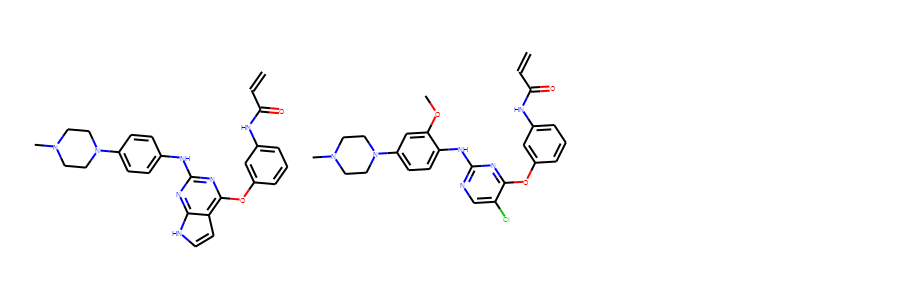

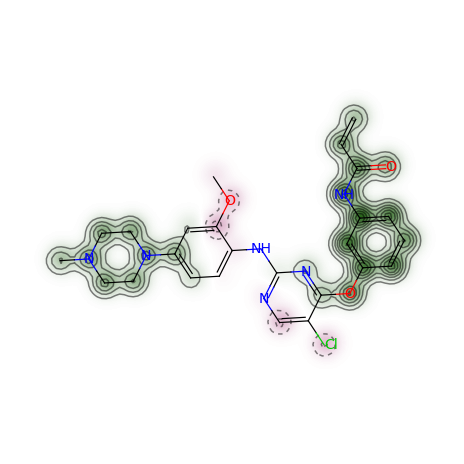

In [86]:
from rdkit.Chem.Draw import SimilarityMaps

ref = mols_sub[0]
mol = mols_sub[1]
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint( ref, mol, SimilarityMaps.GetMorganFingerprint )

Draw.MolsToGridImage( [ref, mol], molsPerRow=3, subImgSize=(300,300) )

Fingerprint descriptors map - charge and logP

Charges =  [-0.09358991854301577, -0.003956975576191903, 0.24726456668062793, -0.2696480622101046, -0.3223931149276884, 0.04467408980828689, -0.038251682852486216, -0.05649333244031857, -0.01907771727455852, 0.13110971938310126, 0.004446080210662932, -0.4380416880747996, 0.23311161342544373, 0.08147895710961545, 0.1463553925152271, -0.029609010346172172, 0.0033924515283658254, -0.3458645436988424, -0.17606141665813105, 0.23205251307006627, -0.19443948118529558, -0.32402056589798, 0.04102571212272887, -0.036468671449766385, -0.0366908199292375, 0.03681005589562408, -0.0366908199292375, -0.036468671449766385, -0.3689647154567249, 0.030576547955533273, 0.01554920108912078, -0.3028559431986506, -0.013239811541794776, 0.01554920108912078, 0.030576547955533273]


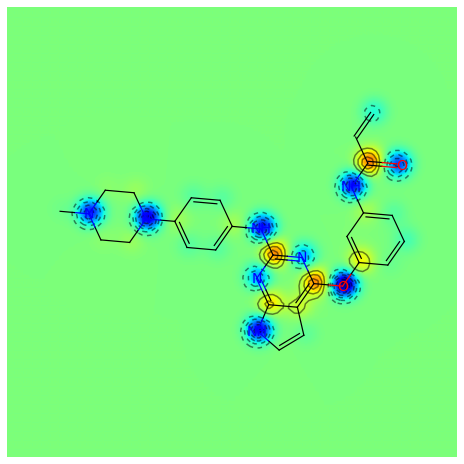

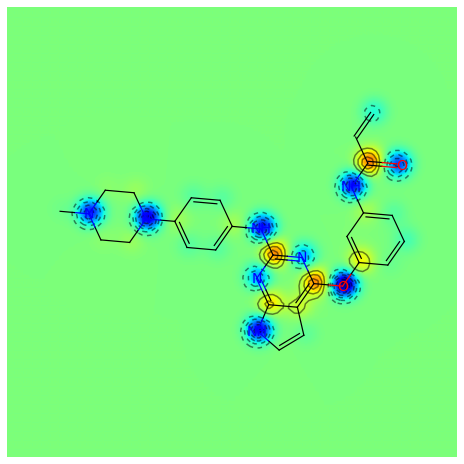

In [93]:
from rdkit.Chem import rdMolDescriptors

m = mols_sub[0]
#m = Chem.MolFromSmiles( 'Cc1c(Nc2nccc(c3cccnc3)n2)cc(NC(c4ccc(CN5CCN(C)CC5)cc4)=O)cc1' )

AllChem.ComputeGasteigerCharges( m )

charges = [ m.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(m.GetNumAtoms()) ]
print( "Charges = ", charges )
SimilarityMaps.GetSimilarityMapFromWeights(m, charges, colorMap='jet', contourLines=10)

(LogP, MR) =  [(0.1551, 3.513), (0.1551, 3.513), (-0.2783, 5.007), (-0.1526, 0.0), (-0.5188, 3.0), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (0.1581, 3.35), (0.5437, 3.853), (0.1581, 3.35), (-0.4195, 1.182), (0.5437, 3.853), (0.2955, 4.346), (0.2955, 4.346), (0.1581, 3.35), (0.1581, 3.35), (-0.3239, 2.202), (-0.3239, 2.202), (0.4619, 4.067), (-0.3239, 2.202), (-0.5188, 3.0), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (-0.4458, 2.819), (-0.2035, 2.753), (-0.2035, 2.753), (-0.3187, 1.839), (-0.2035, 2.753), (-0.2035, 2.753), (-0.2035, 2.753)]


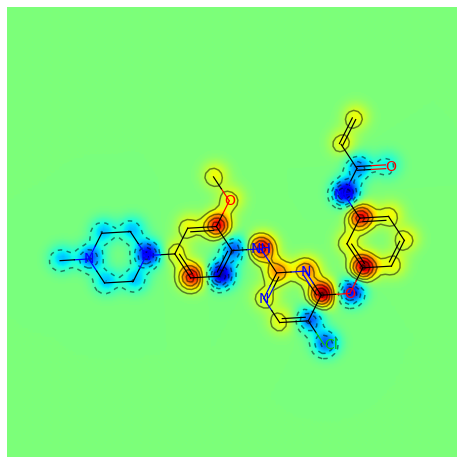

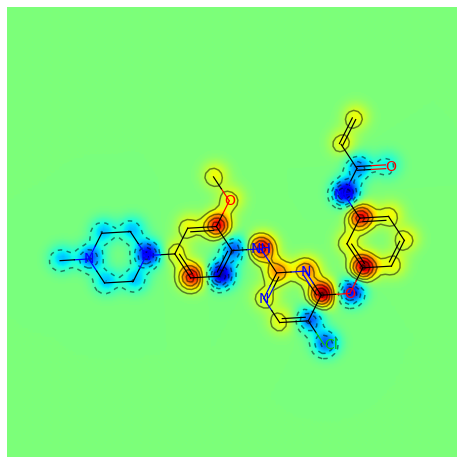

In [94]:
logpmr = rdMolDescriptors._CalcCrippenContribs(m)
print( "(LogP, MR) = ", logpmr )
SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in logpmr], colorMap='jet', contourLines=10)

SMIRKS - Chemical Reactions

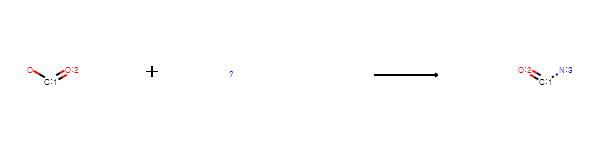

In [95]:
rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])-[OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]')
rxn

2


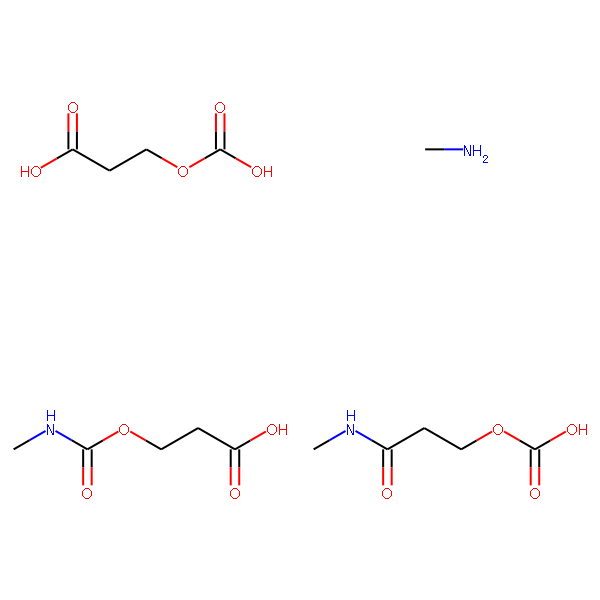

In [96]:
rx1 = Chem.MolFromSmiles('C(COC(=O)O)C(=O)O')
rx2 = Chem.MolFromSmiles('NC')
ps = rxn.RunReactants((rx1,rx2) )
print( len(ps) )
Draw.MolsToGridImage( [ rx1, rx2, ps[0][0], ps[1][0] ], molsPerRow=2, subImgSize=(300,300) )

RECAP

dict_keys(['*C(=O)CC', '*OCCOc1ccccc1', '*c1ccccc1', '*CCOC(=O)CC', '*CCOc1ccccc1'])


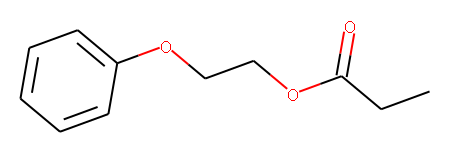

In [99]:
from rdkit.Chem import Recap
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
# m = Chem.MolFromSmiles( 'Cc1c(Nc2nccc(c3cccnc3)n2)cc(NC(c4ccc(CN5CCN(C)CC5)cc4)=O)cc1' )
hierarch = Recap.RecapDecompose(m)
print( hierarch.children.keys() )
hierarch.mol